# Delay payments prediction model

* Scope of the the study is deployment of a model predicting customers payment delays.

In [2]:
import pandas as pd
import numpy as np


In [3]:
customer_base = pd.read_excel('customer_profile.xlsx', sheet_name='customers_profile_2021')

In [4]:
customer_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2492 entries, 0 to 2491
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CardCode            2492 non-null   object 
 1   CustomerRank        2492 non-null   int64  
 2   Domestic            2492 non-null   int64  
 3   Attika              2492 non-null   int64  
 4   Territory           2492 non-null   int64  
 5   U_GRSL              2488 non-null   float64
 6   U_ZeeKey2           2492 non-null   int64  
 7   SZSegmentation      2289 non-null   object 
 8   MarketSegmentation  2214 non-null   object 
 9   Subsegment          2390 non-null   object 
 10  SlpCode             2492 non-null   int64  
 11  AvgPayDays          2492 non-null   float64
 12  PaymentTerms        2492 non-null   int64  
 13  AvgLatePayDays      2492 non-null   int64  
 14  Tziros              2492 non-null   float64
 15  AvgSVal             2492 non-null   float64
 16  MaxSva

In [ ]:
for column in customer_base.columns[2:-2]:
    print(f"############# START {column} #############")
    print(customer_base[column].value_counts())
    print(f"############# END {column} #############")

In [5]:
customer_base.head()


,CardCode,CustomerRank,Domestic,Attika,Territory,U_GRSL,U_ZeeKey2,SZSegmentation,MarketSegmentation,Subsegment,SlpCode,AvgPayDays,PaymentTerms,AvgLatePayDays,Tziros,AvgSVal,MaxSval,invNo,AvgInvNoPerMonth,ranking
0,A.00001,6,0,1,130,0.0,5,NaN,NaN,NaN,64,0.00,210,-210,486810.83,21165.69,43385.5,23,2,"0119001004, 0018007003, 0127003001, 0026007003..."
1,A.00008,35,0,1,126,0.0,5,NaN,NaN,NaN,64,48.68,45,4,91826.00,15304.33,19551.0,6,1,"0094079001, 0025022020, 0094013002"
2,A.00023,43,0,1,134,0.0,4,NaN,NaN,NaN,64,117.00,62,55,68544.00,34272.00,36120.0,2,1,0005001010
3,A.00028,161,0,1,131,0.0,4,NaN,NaN,NaN,64,13.39,30,-17,14910.65,4970.22,5801.7,3,1,"0015035000, 0001026020, 0068001001, 0135000000..."
4,A.00032,2,0,1,123,0.0,4,NaN,NaN,NaN,64,26.69,1,26,1207838.62,25698.69,54926.6,47,3,"0015042001, 0095005001, 0026008002, 0025006010..."


In [6]:
customer_base['AvgLatePayDays_Buckets'] = customer_base['AvgLatePayDays'].apply(lambda days: days//20 * 20)
customer_base_filtered = customer_base[customer_base['AvgLatePayDays'] >= 0]

In [7]:
customer_base_filtered.head()

,CardCode,CustomerRank,Domestic,Attika,Territory,U_GRSL,U_ZeeKey2,SZSegmentation,MarketSegmentation,Subsegment,...,AvgPayDays,PaymentTerms,AvgLatePayDays,Tziros,AvgSVal,MaxSval,invNo,AvgInvNoPerMonth,ranking,AvgLatePayDays_Buckets
1,A.00008,35,0,1,126,0.0,5,NaN,NaN,NaN,...,48.68,45,4,91826.00,15304.33,19551.00,6,1,"0094079001, 0025022020, 0094013002",0
2,A.00023,43,0,1,134,0.0,4,NaN,NaN,NaN,...,117.00,62,55,68544.00,34272.00,36120.00,2,1,0005001010,40
4,A.00032,2,0,1,123,0.0,4,NaN,NaN,NaN,...,26.69,1,26,1207838.62,25698.69,54926.60,47,3,"0015042001, 0095005001, 0026008002, 0025006010...",20
5,A.00033,5,0,1,139,0.0,4,NaN,NaN,NaN,...,58.54,1,58,560209.79,28010.49,46480.50,20,1,"0015042001, 0025006010, 0015033000, 0026010001...",40
6,A.00035,12,0,1,120,0.0,4,NaN,NaN,NaN,...,63.72,62,2,240023.19,10435.79,27756.06,23,1,"0025006000, 0127010000, 0025017001, 0025006010...",0


array([[<AxesSubplot:title={'center':'AvgLatePayDays_Buckets'}>]],
      dtype=object)

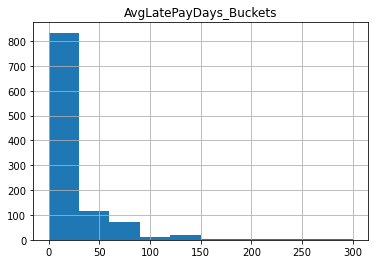

In [8]:
customer_base_filtered.hist(['AvgLatePayDays_Buckets'])

In [9]:
customer_base_filtered.isnull().sum()

CardCode                    0
CustomerRank                0
Domestic                    0
Attika                      0
Territory                   0
U_GRSL                      0
U_ZeeKey2                   0
SZSegmentation             87
MarketSegmentation        117
Subsegment                 36
SlpCode                     0
AvgPayDays                  0
PaymentTerms                0
AvgLatePayDays              0
Tziros                      0
AvgSVal                     0
MaxSval                     0
invNo                       0
AvgInvNoPerMonth            0
ranking                     0
AvgLatePayDays_Buckets      0
dtype: int64

In [10]:
customer_base_cleaned = customer_base_filtered.dropna()

In [11]:
customer_base_cleaned.isnull().sum()

CardCode                  0
CustomerRank              0
Domestic                  0
Attika                    0
Territory                 0
U_GRSL                    0
U_ZeeKey2                 0
SZSegmentation            0
MarketSegmentation        0
Subsegment                0
SlpCode                   0
AvgPayDays                0
PaymentTerms              0
AvgLatePayDays            0
Tziros                    0
AvgSVal                   0
MaxSval                   0
invNo                     0
AvgInvNoPerMonth          0
ranking                   0
AvgLatePayDays_Buckets    0
dtype: int64

In [45]:
X = customer_base_cleaned.drop(['CardCode',"CustomerRank",'AvgPayDays', "SlpCode","invNo",'AvgLatePayDays_Buckets','Attika','U_GRSL','U_ZeeKey2',"ranking"], axis=1)
y = customer_base_cleaned['AvgLatePayDays_Buckets']

In [46]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
str_columns = [column for column in X.columns if customer_base_cleaned[column].dtype == 'object']
X[str_columns] = enc.fit_transform(X[str_columns])

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
cross_val_score(clf, X,y)

C:\Users\netadmin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


array([0.98947368, 0.98421053, 0.98421053, 0.97354497, 0.98941799])

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)
clf.fit(X_train,y_train)

DecisionTreeClassifier(random_state=0)

In [56]:
clf.predict(X_test)

array([ 20,  20,  20,  60,  20,  60,   0,   0,  20,   0,  20,  20,  20,
        40,   0,   0,  40, 280,  20,   0,   0, 120,   0,   0,  40,  20,
         0,   0,   0,   0,   0,   0,  20,   0,  20,   0,   0,  40,   0,
       120,  40,  20,  20,   0,  20, 120,   0,   0,   0,  20,   0,  40,
        40,   0,  40,  20,   0,   0,  20,  60,   0,   0,  20,   0,  20,
         0,  80,   0,   0,   0,   0,  20,   0,  40,   0,  20,  40,  60,
         0,   0, 280,  40, 280,   0,   0,   0,  20,   0,   0,   0,   0,
         0,  40,   0, 200,  40,  20,   0,  20, 100,   0,   0,   0,  20,
         0,   0,  20,  20,   0,   0,  20,   0,   0,  20,   0,  80,   0,
         0,  20,   0,  20,   0,   0,   0,  40,  80,   0,  40,   0,  60,
         0,  40, 120, 120,   0,   0,   0,   0,   0, 120,  40,  40,   0,
       200,   0,  80,  20,  20,  20,  20,   0,   0,   0,  20,  20,   0,
         0,   0,   0,   0,   0,  20,   0,  20,   0,  40,   0,  20,   0,
       140,  20,   0,   0, 100,  40,   0,   0,  20,  60,   0,   

In [57]:
from sklearn.metrics import zero_one_loss

print("Training error =", zero_one_loss(y_test, clf.predict(X_test)))

Training error = 0.029535864978902926


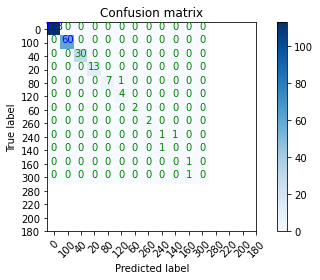

In [52]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="blue" if cm[i, j] > thresh else "green")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()  
    plt.show()

cm = confusion_matrix(y_test, clf.predict(X_test))

plot_confusion_matrix(cm, y.unique())

In [24]:
cm = confusion_matrix(y_test, clf.predict(X_test))

In [36]:
cm

array([[113,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  60,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  30,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  13,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   7,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   4,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0]],
      dtype=int64)

In [37]:
from sklearn.neural_network import MLPClassifier
clf_nn = MLPClassifier(hidden_layer_sizes=(100,100, 100, 100, 100))
cross_val_score(clf_nn, X,y)

C:\Users\netadmin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


array([0.35789474, 0.39473684, 0.47368421, 0.56084656, 0.5026455 ])

In [38]:
from sklearn.svm import LinearSVC
clf_svm = LinearSVC()
cross_val_score(clf_svm, X_train, y_train)

C:\Users\netadmin\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\netadmin\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\netadmin\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\netadmin\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\netadmin\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to c

array([0.54545455, 0.62676056, 0.51408451, 0.64788732, 0.49295775])

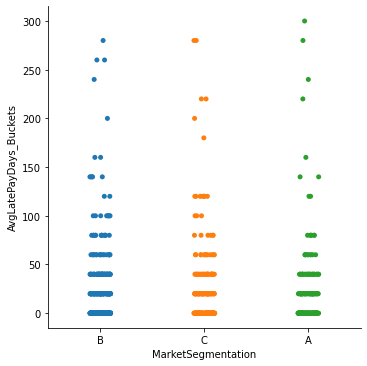

In [68]:
sns.catplot(x="MarketSegmentation", y="AvgLatePayDays_Buckets", data=customer_base_filtered)

## Models results visualization